# i ] Création de l'environnement :

![title](representation_envi.png)

#### We'll use the OpenAI Gym framework to build our environement

In [22]:
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class AugmentedGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}
    
        
    def __init__(self):
        
        self.shape = (10, 20)
        self.nS = np.prod(self.shape)
        self.nA = 4
        
        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=np.bool)
        self._cliff[0, 12:15] = True; self._cliff[1, 10:13] = True
        self._cliff[9, 3] = True; self._cliff[9, 5:7] = True; self._cliff[8, 3:4] = True; self._cliff[7, 4:7] = True; self._cliff[6, 5:7] = True
        self._cliff[3, 18] = True; self._cliff[4, 17:20] = True; self._cliff[8, 14] = True; self._cliff[9, 16:18] = True
        
        #Big cheese location
        self._cheese = np.zeros(self.shape, dtype=np.bool)
        self._cheese[7,17] = True
        #self._cheese[7,16] = True;
        self._cheese[9,2] = True
        
        #Carrots initial location
        self._ini_carrots= np.zeros(self.shape, dtype=np.bool)
        self._ini_carrots[2, 4] = True
        self._ini_carrots[5, 2] = True; self._ini_carrots[1, 8] = True
        self._ini_carrots[8, 10] = True; self._ini_carrots[7, 11] = True
        self._ini_carrots[1, 13:14] = True; self._ini_carrots[1, 18] = True
        
        self._carrots = np.copy(self._ini_carrots)

        # Wind location and strenghts
        self._winds = np.zeros(self.shape)
        self._winds[7:9 ,0:3] = 1; self._winds[6,3] = 1
        self._winds[1,9] = 1
        self._winds[3,15:18] = 1; self._winds[4,14] = 1
        
        # Walls Location
        self._walls = np.zeros(self.shape, dtype=np.bool)
        self._walls[0:4,5] = True 
        self._walls[4,10:13] = True 
        self._walls[5:9,13] = True
        
        # We always start in state (0, 0)
        self.ini_state = np.ravel_multi_index((0,0), self.shape)
        isd = np.zeros(self.nS)
        isd[self.ini_state] = 1.0
                                
        # Calculate transition probabilities
        self.P = {}
        self._actualize_transition_probabilities()

        super(AugmentedGridworldEnv, self).__init__(self.nS, self.nA, self.P, isd)
        
        
    def _actualize_transition_probabilities(self): #once we have eaten the carrot, we have to compute again those probabilities
        
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape) #gives the couple (x,y) from the indice of the state (ex:18 -> (2,8))
    
            self.P[s] = { a : [] for a in range(self.nA)}
            self.P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            self.P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            self.P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            self.P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])
        
    def _limit_coordinates(self, coord): #To be sure that we are in the admissible states
        coord[0] = min(coord[0], self.shape[0] - 1) #for right-overtaking
        coord[0] = max(coord[0], 0) #for left overtaking
        coord[1] = min(coord[1], self.shape[1] - 1)  #for botom overtaking
        coord[1] = max(coord[1], 0) # for up overtaking
        return coord

    def _calculate_transition_prob(self, current, delta):
        
        new_position = np.array(current) + np.array(delta) + np.array([0, 1]) * self._winds[tuple(current)] #[0,1] because wind push you to right
        new_position = self._limit_coordinates(new_position).astype(int) #to be sure that we stay in the frame
        new_state = np.ravel_multi_index(tuple(new_position), self.shape) #from coordinates couple to flat index
        
        proba = 1.0 #no noise on dispalcements
        
        if self._cliff[tuple(new_position)]:
            reward = -100.0
        elif self._cheese[tuple(new_position)]:
            reward = +50.0 
        elif self._carrots[tuple(new_position)]: #+3 for a carrot
            reward = +3.0
        elif self._walls[tuple(new_position)]: # if new state is a wall, probability = 0
            proba = 0; reward = 0
        else: # no element on this state
            reward = -1 #-1 for a classic displacement
        
        is_done = self._cliff[tuple(new_position)] or self._cheese[tuple(new_position)] #end if cliffs or big cheese
        
        return [(proba, new_state, reward, is_done)]
    
    def step(self, action):
        
        state, reward, done, proba = super().step(action) #we overwrite the method of the global env (with super().)
        position = np.unravel_index(state, self.shape)

        if self._carrots[tuple(position)]: #we remove the carrot if we get it
            self._carrots[tuple(position)] = False
            self._actualize_transition_probabilities()
        
        return state, reward, done, proba
    
    def reset(self,):
        super().reset()
        self._carrots = np.copy(self._ini_carrots)
        self._actualize_transition_probabilities()
        return self.ini_state
    
    
    def render(self, mode='human', close=False): #public method
        self._render(mode, close)

    def _render(self, mode='human', close=False): # private method
        
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            
            position = np.unravel_index(s, self.shape)
            
            if self.s == s:
                output = u"\U0001F42D"
            elif self._cliff[position]:  #tuple
                output = u"\U0001F30A"
            elif self._cheese[position]:
                output = u"\U0001F9C0"
            elif self._carrots[position]: #+3 for a small cheese
                output = u"\U0001F955"
            elif self._walls[position]: # if new state is a wall, probability = 0, else = 1 (no noisy movements)
                output = u"\u2588"
            elif self._winds[position]: # if new state is a wall, probability = 0, else = 1 (no noisy movements)
                output = u"\u21D2"
            else:
                output = " " + u"\u25CB"

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
            
        outfile.write("\n")
    
    def render_policy(self, reshaped_policy, close=False): 
        
        if close:
            return

        outfile = sys.stdout

        for s in range(self.nS):
            
            position = np.unravel_index(s, self.shape)
            
            if reshaped_policy[position] == 0:
                output = u"\u2191"
            elif reshaped_policy[position] == 1:
                output = u"\u2192"
            elif reshaped_policy[position] == 2:
                output = u"\u2193"
            elif reshaped_policy[position] == 3:
                output = u"\u2190"

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
            
        outfile.write("\n")
    
    
    def render_trajectory(self, states_trajectory, rewards_trajectory=None):
        
        self.reset()
        self.reward_matrix = np.zeros(self.shape)
        self.reward_matrix[self._cliff] = -100
        self.reward_matrix[self._carrots] = 3
        self.reward_matrix[self._cheese] = 50
        
        plt.figure(figsize=(10,5))
        
        if rewards_trajectory != None:
            plt.subplot(121)

        plt.imshow(self.reward_matrix, 'jet')
        c = cm.OrRd(np.linspace(0, 1, len(states_trajectory)))
        plt.scatter(np.unravel_index(states_trajectory, self.shape)[1], np.unravel_index(states_trajectory, self.shape)[0], color=c)
        
        if rewards_trajectory != None:
            plt.subplot(122)
            plt.plot(np.array(rewards_trajectory))
        
        plt.show()

In [23]:
env = AugmentedGridworldEnv()

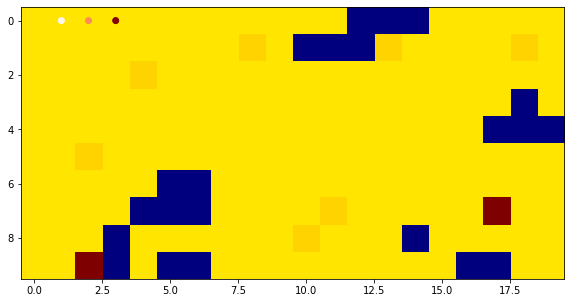

In [24]:
env.render_trajectory([1,2,3])